# Pairs Trading
This strategy uses a Kalman filter to calculate the spread between two already-selected cointegrated stocks. We then use the spread to make trading decisions.

In [19]:
from datetime import datetime, timedelta
import logging

from alpaca.data.timeframe import TimeFrame, TimeFrameUnit
import pandas as pd
import numpy as np

import statsmodels.api as sm
from talib import ATR, EMA, RSI
import matplotlib.pyplot as plt

from examples.data import (
    download_bars,
    separate_bars_by_symbol,
    split_multi_index_bars_train_test,
)

from bacta.backtester import EventBacktester, Order, Position
from bacta.utilities import dash
from bacta.utilities.logger import get_logger, set_log_level

set_log_level(logging.DEBUG)
logger = get_logger(__name__)

Cointegrated pairs are selected in a different notebook.

In [20]:
# we already know these are cointegrated
symbols = ["CMS", "DTE"]

bars = download_bars(
    symbols,
    start_date=datetime(2023, 7, 31),
    end_date=datetime(2025, 7, 31),
    timeframe=TimeFrame(1, TimeFrameUnit.Hour)
)
# split the bars into train and test
train_bars, test_bars = split_multi_index_bars_train_test(
    bars, split_ratio=0.9)

# get c
close_prices = train_bars["close"].unstack(level=0)

[2025-08-10 11:57:28][DEBUG] Loading data/CMSDTE_2023-07-31_2025-07-31_1Hour.pkl


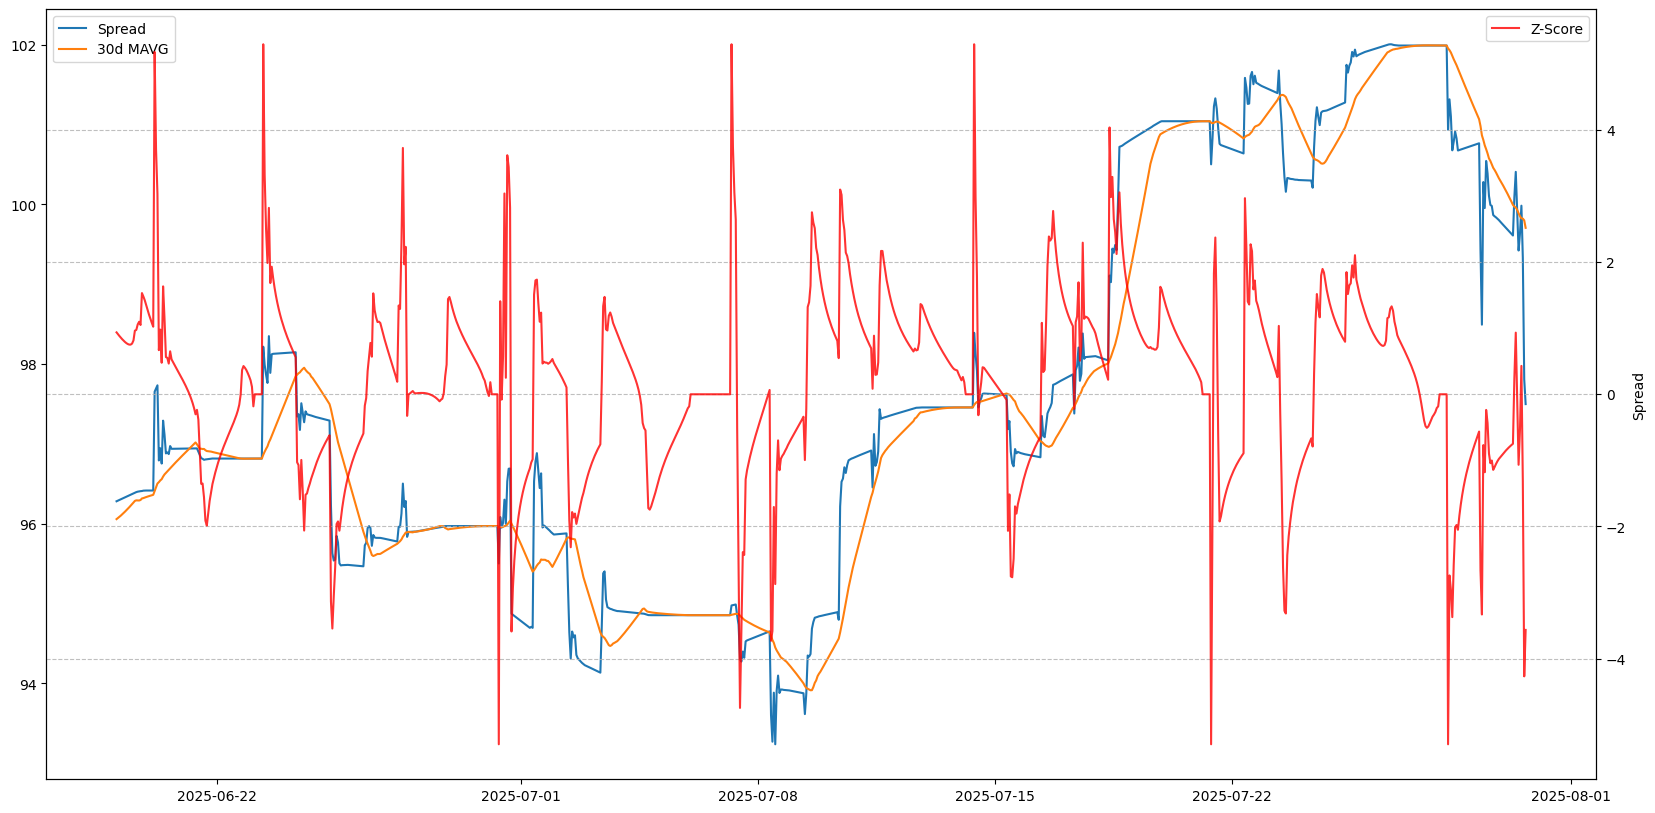

In [21]:
# Get the spread between the 2 stocks
# Calculate rolling beta coefficient
S1 = close_prices[symbols[0]]
S2 = close_prices[symbols[1]]
window = 30
rolling_beta = [np.nan] * window
for n in range(window, len(S1)):
    y = S1[(n - window):n]
    X = S2[(n - window):n]
    rolling_beta.append(sm.OLS(y, X).fit().params.iloc[0])

rolling_beta = pd.Series(rolling_beta, index=S2.index)

# now do it with test bars
S1 = test_bars["close"].unstack(level=0)[symbols[0]]
S2 = test_bars["close"].unstack(level=0)[symbols[1]]
rolling_beta = [np.nan] * window
for n in range(window, len(S1)):
    y = S1[(n - window):n]
    X = S2[(n - window):n]
    rolling_beta.append(sm.OLS(y, X).fit().params.iloc[0])

spread = S2 - rolling_beta * S1
spread.name = 'spread'

# Get the 30 day moving average
spread_mavg30 = spread.rolling(window=window).mean()
spread_mavg30.name = 'spread 30d mavg'
# Take a rolling 30 day standard deviation
std_30 = spread.rolling(window=window).std()
std_30.name = 'std 30d'
# Calculate the z-score
zscore = (spread - spread_mavg30) / std_30
zscore = zscore.fillna(0) # for when spread = 0
zscore.name = 'zscore'

fig = plt.figure(figsize=(20, 10))
tail = 1000
plt.plot(spread.index[-tail:], spread.values[-tail:], label='Spread')
plt.plot(spread_mavg30.index[-tail:], spread_mavg30.values[-tail:], label='30d MAVG')
plt.legend(loc='upper left')

# also plot the zscore with secondary y axis
ax2 = plt.twinx()
ax2.plot(zscore.index[-tail:], zscore.values[-tail:], color='red', label='Z-Score', alpha=0.8)
plt.legend(loc='upper right')
ax2.set_ylabel('Z-Score')
plt.ylabel('Spread');
plt.grid(linestyle='--', alpha=0.8)
plt.show()

Make a backtester that uses the zscore to make trading decisions. We will have to recompute all values each new bar (so in the _update_state method).

In [22]:

class PairsStrategy(EventBacktester):
    """
    Backtester that uses the pairs trading strategy.
    """

    def __init__(self, active_symbols, cash, **kwargs):
        super().__init__(active_symbols, cash, **kwargs)
        self.window = 30
        self.rolling_stats = pd.DataFrame(
            columns=["spread", "spread_mavg30", "std_30", "zscore", "rolling_beta"])

    def precompute_step(self, bars: pd.DataFrame):
        """
        Preload the indicators for the backtest.
        """
        close_prices = bars["close"].unstack(level=0)
        S1 = close_prices[self.active_symbols[0]]
        S2 = close_prices[self.active_symbols[1]]
        rolling_beta = [np.nan] * self.window
        for n in range(self.window, len(S1)):
            y = S1[(n - self.window):n]
            X = S2[(n - self.window):n]
            rolling_beta.append(sm.OLS(y, X).fit().params.iloc[0])

        rolling_beta = pd.Series(rolling_beta, index=S2.index)

        # Compute the rolling stats as new rows and append to self.rolling_stats
        spread = S2 - rolling_beta * S1
        spread_mavg30 = spread.rolling(window=self.window).mean()
        std_30 = spread.rolling(window=self.window).std()
        zscore = (spread - spread_mavg30) / std_30
        zscore = zscore.fillna(0)  # for when spread = 0

        # Create a DataFrame with the new stats
        self.rolling_stats = pd.DataFrame({
            "spread": spread,
            "spread_mavg30": spread_mavg30,
            "std_30": std_30,
            "zscore": zscore,
            "rolling_beta": rolling_beta
        }, index=spread.index)

    def update_step(self, bars: pd.DataFrame, index: pd.Timestamp):
        """
        Update the state of the backtester.
        """
        close_prices = bars["close"].unstack(
            level=0)  # these are the full bars
        S1 = close_prices[self.active_symbols[0]]
        S2 = close_prices[self.active_symbols[1]]

        rolling_beta = sm.OLS(S1, S2).fit().params.iloc[0]

        spread = S2 - rolling_beta * S1
        spread_mavg30 = spread.rolling(window=self.window).mean()
        std_30 = spread.rolling(window=self.window).std()
        zscore = (spread - spread_mavg30) / std_30
        zscore = zscore.fillna(0)  # for when spread = 0

        self.rolling_stats = pd.concat([self.rolling_stats, pd.DataFrame({
            "spread": spread,
            "spread_mavg30": spread_mavg30,
            "std_30": std_30,
            "zscore": zscore,
            "rolling_beta": rolling_beta
        }, index=[index])])

    def generate_orders(self, bar: pd.DataFrame, index: pd.Timestamp) -> list[Order]:
        """
        Make a decision based on the prices.
        """
        close_prices = bar.loc[:, "close"]
        # if zscore is > 1, then sell the pair
        # if zscore is < -1, then buy the pair
        # if zscore is between -1 and 1, then do nothing
        orders = []

        s1_quantity = 200 / close_prices[self.active_symbols[0]]
        s2_quantity = s1_quantity / self.rolling_stats.iloc[-1]["rolling_beta"]


        if self.rolling_stats.iloc[-1]["zscore"] > 3:
            orders.append(Order(
                self.active_symbols[1], Position.SHORT, close_prices[self.active_symbols[1]], s2_quantity))
            orders.append(Order(
                self.active_symbols[0], Position.LONG, close_prices[self.active_symbols[0]], s1_quantity))
        elif self.rolling_stats.iloc[-1]["zscore"] < -3:
            orders.append(Order(
                self.active_symbols[1], Position.LONG, close_prices[self.active_symbols[1]], s2_quantity))
            orders.append(Order(
                self.active_symbols[0], Position.SHORT, close_prices[self.active_symbols[0]], s1_quantity))
        return orders



In [23]:
# create the backtester
backtester = PairsStrategy(
    symbols,
    cash=2000,
    allow_short=True,
    min_cash_balance=100,
    max_short_value=1000,
    min_trade_value=1,
    market_hours_only=True,
    transaction_cost=0.000,
    transaction_cost_type="percentage",
)

# preload the train bars
backtester.load_train_bars(train_bars)

# run_backtest the backtest
backtester.run_backtest(test_bars)


[2025-08-10 11:57:31][DEBUG] Initializing backtester with active symbols: ['CMS', 'DTE'], cash: 2000, allow_short: True, min_cash_balance: 100, max_short_value: 1000, min_trade_value: 1, market_hours_only: True
[2025-08-10 11:57:34][INFO] Train bars have been previously loaded. Concatenating with test bars...
[2025-08-10 11:57:34][INFO] Running backtest over 19281 bars from 2025-05-18 16:00:00-04:00 to 2025-07-30 16:00:00-04:00...
[2025-08-10 11:57:34][DEBUG] Placing LONG 5.2065 DTE @ $135.420 (2025-05-21 10:00:00-04:00)
[2025-08-10 11:57:34][DEBUG] Placing SHORT 2.8301 CMS @ $70.670 (2025-05-21 10:00:00-04:00)
[2025-08-10 11:57:34][DEBUG] Placing SHORT 5.3229 DTE @ $135.070 (2025-05-23 13:00:00-04:00)
[2025-08-10 11:57:34][DEBUG] Placing LONG 2.8927 CMS @ $69.140 (2025-05-23 13:00:00-04:00)
[2025-08-10 11:57:34][DEBUG] Placing SHORT 5.3129 DTE @ $135.290 (2025-05-23 14:00:00-04:00)
[2025-08-10 11:57:34][DEBUG] Placing LONG 2.8873 CMS @ $69.270 (2025-05-23 14:00:00-04:00)
[2025-08-10 1

,cash,portfolio_value,CMS,DTE
0,2000.000000,2000.000000,0.000000,0.000000
2025-05-18 16:00:00-04:00,2000.000000,2000.000000,0.000000,0.000000
2025-05-18 17:00:00-04:00,2000.000000,2000.000000,0.000000,0.000000
2025-05-18 18:00:00-04:00,2000.000000,2000.000000,0.000000,0.000000
2025-05-18 19:00:00-04:00,2000.000000,2000.000000,0.000000,0.000000
...,...,...,...,...
2025-07-30 12:00:00-04:00,726.140912,2046.560471,2.856430,8.110626
2025-07-30 13:00:00-04:00,726.140912,2049.906990,2.856430,8.110626
2025-07-30 14:00:00-04:00,726.140912,2043.439456,2.856430,8.110626
2025-07-30 15:00:00-04:00,200.001697,2028.834484,0.068585,13.475526


plotting...


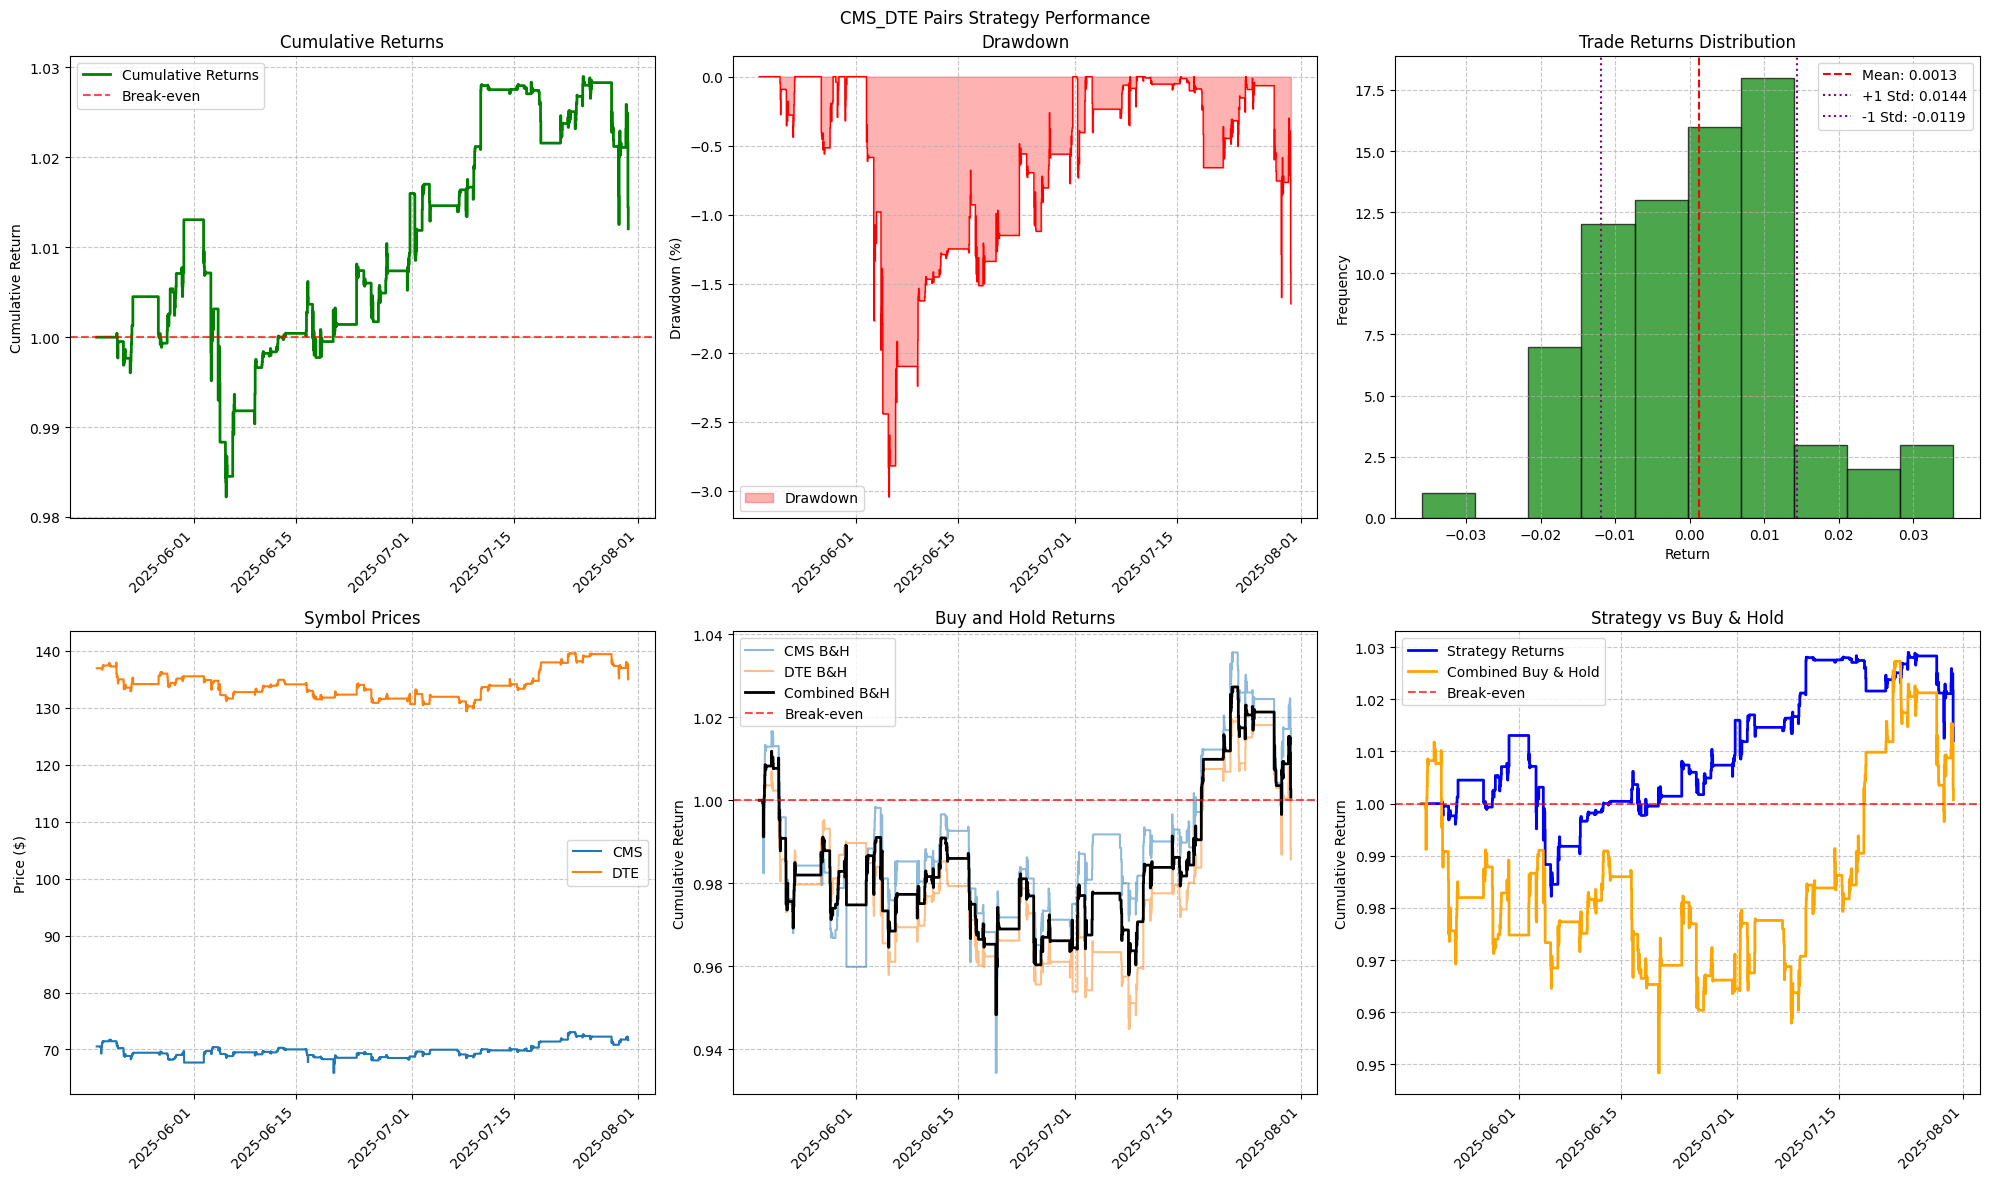

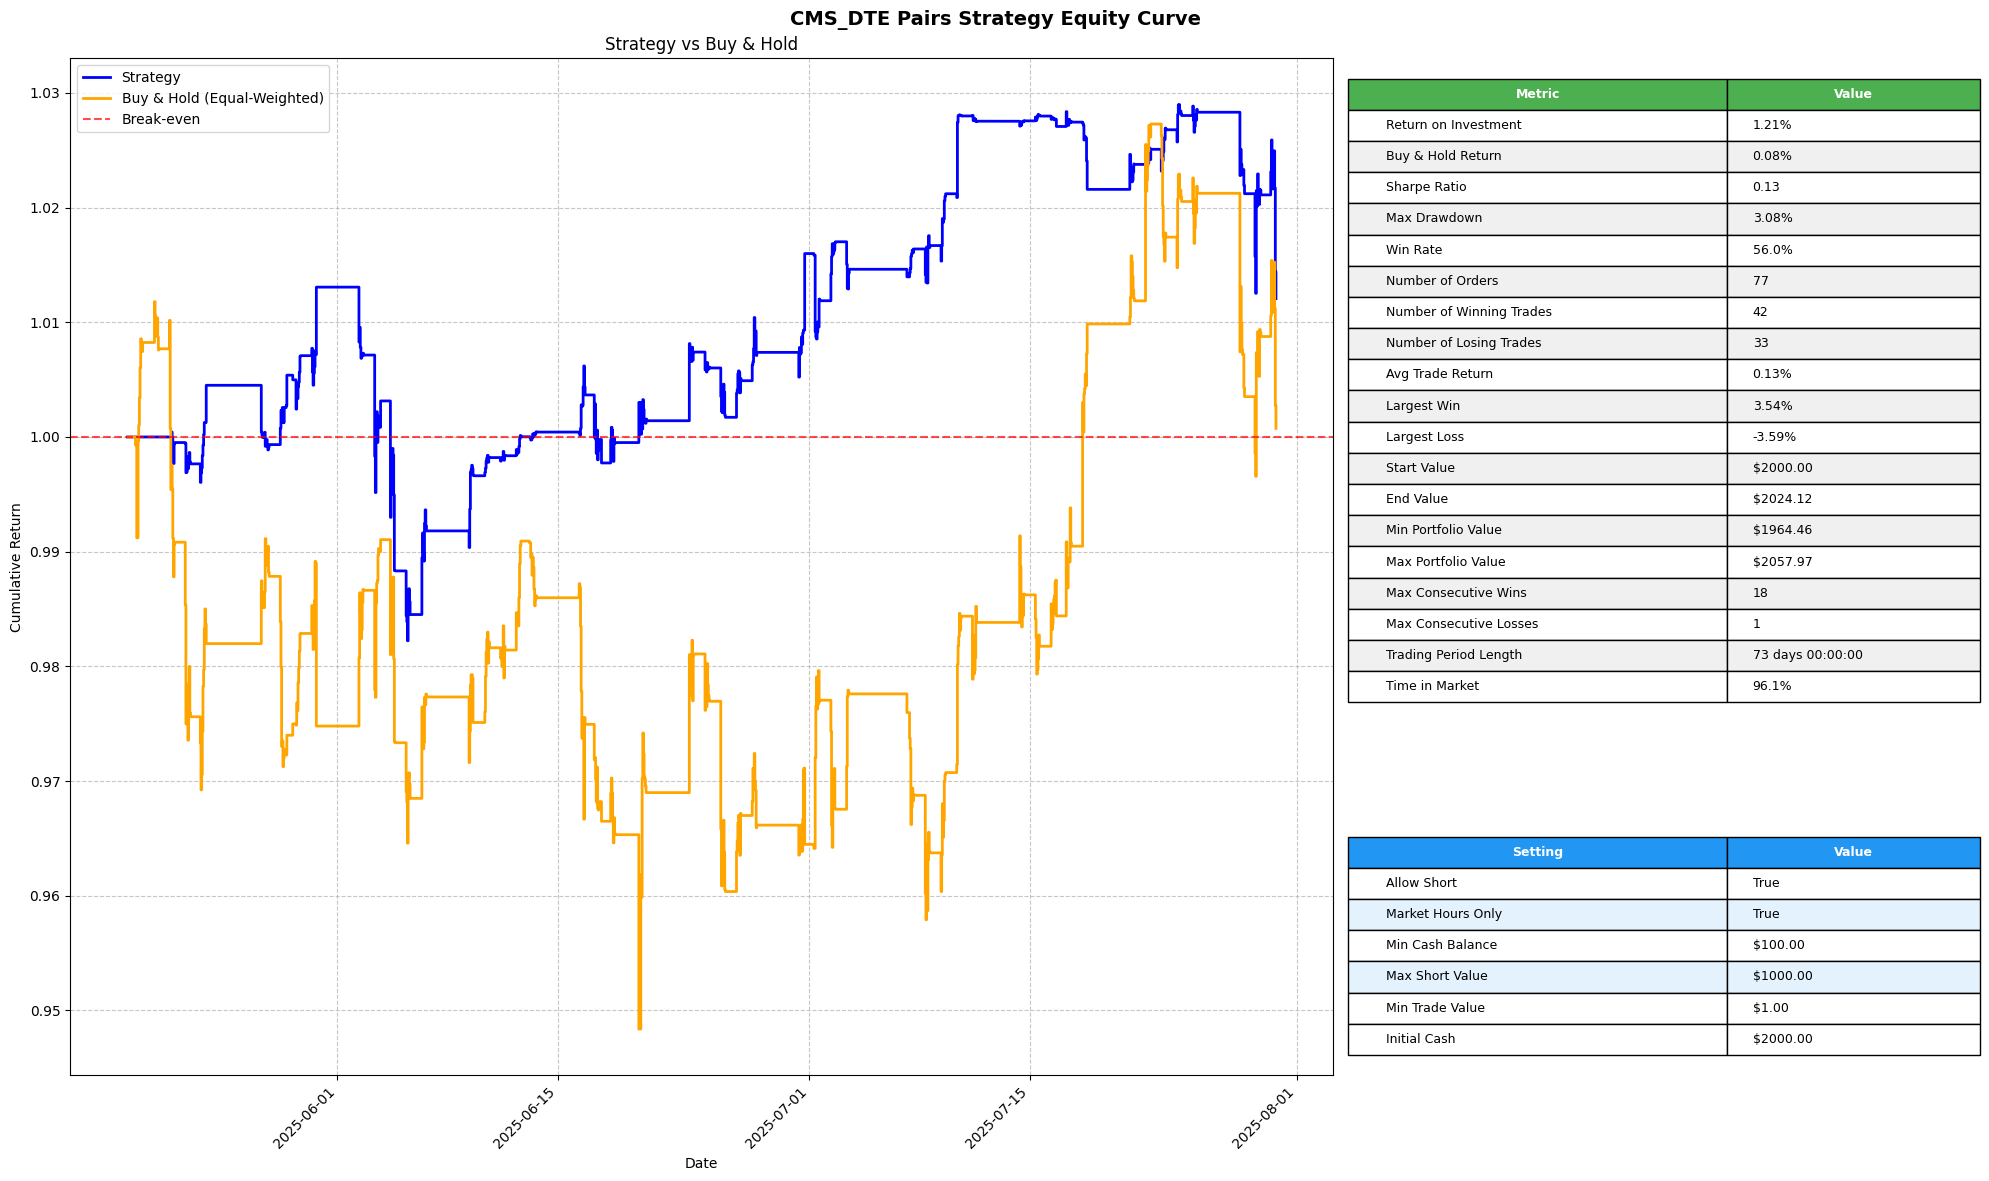

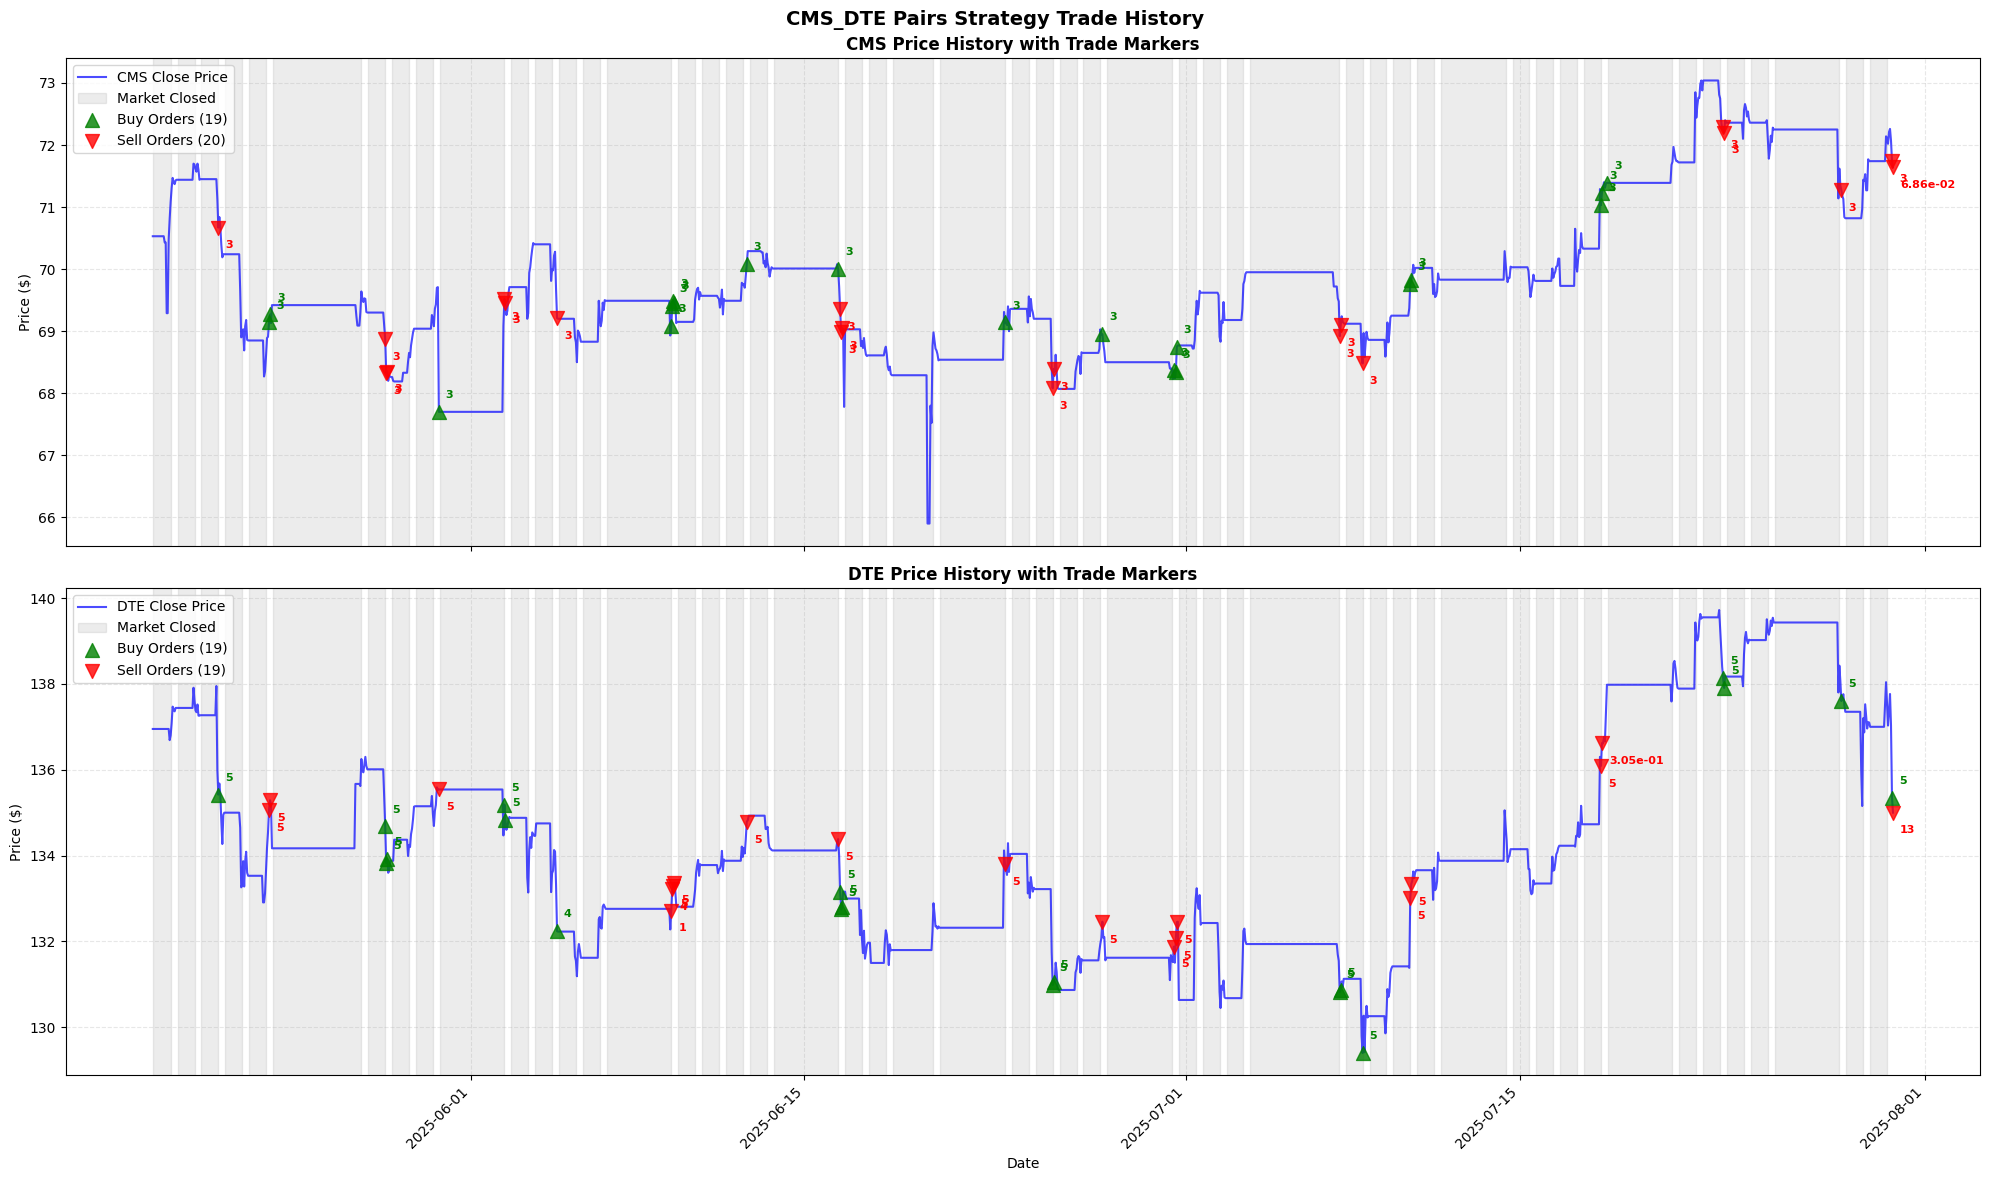

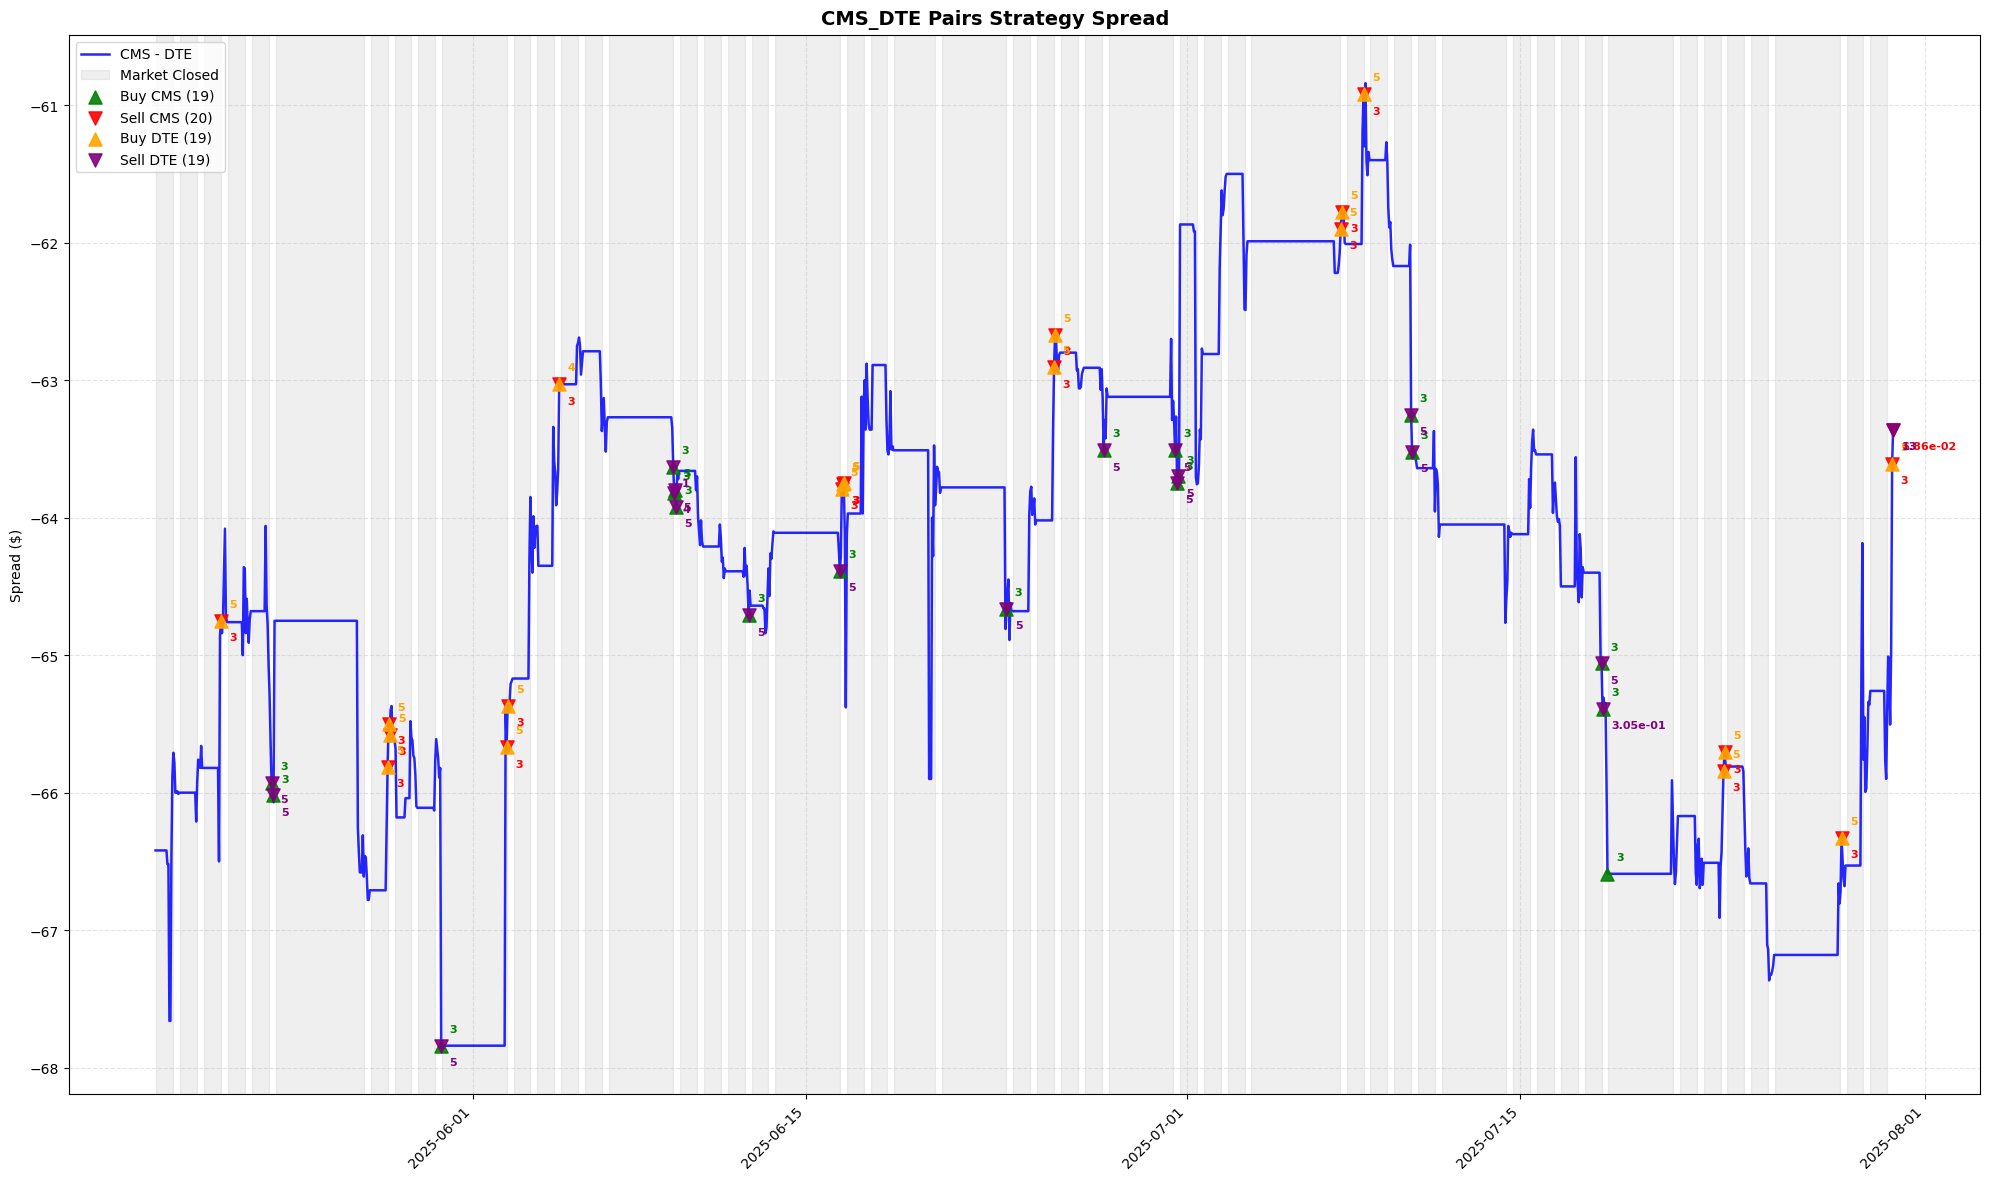

In [24]:
# Plot the results
print("plotting...")
backtester.plot_performance_analysis(
    title="_".join(symbols) + " Pairs Strategy Performance", show_plot=True)
backtester.plot_equity_curve(
    title="_".join(symbols) + " Pairs Strategy Equity Curve", show_plot=True)
_ = backtester.plot_trade_history(
    title="_".join(symbols) + " Pairs Strategy Trade History", show_plot=True)
_ = backtester.plot_pairs_spread(
    title="_".join(symbols) + " Pairs Strategy Spread", show_plot=True)